# **0. Data and library Imports**

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Bidirectional, Dense
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv('data/data_bersih.csv')
df.head()

,sentimen,tweet,_exclaim,_question,_upper_rt,tweet_pp
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,1,2,0.030769,prabowo indonesia tidak dihargai bangsa asing ...
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",0,1,0.139785,batuan langka hadiah habib luthfi seharga mercy ?
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....",0,0,0.103175,era indonesia baik indonesiamaju jokowilagi
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...",1,0,0.054688,sumatera selatan asian games berdampak percaya...
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,0,0,0.008197,negara ngutang bingung infrastruktur dipakai m...


In [4]:
text_col, target_col = "tweet_pp", "sentimen"
X_all = df[text_col].astype(str).values
le = LabelEncoder()
y_all = le.fit_transform(df[target_col].astype(str).values)

# Train/Test (15%), lalu Train/Val (15% dari train)
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.15, random_state=16, stratify=y_all
)
X_tr_text, X_val_text, y_tr, y_val = train_test_split(
    X_train_text, y_train, test_size=0.15, random_state=7, stratify=y_train
)

# cek
print(X_tr_text.shape,X_val_text.shape, X_test_text.shape)

(1310,) (232,) (273,)


In [42]:
# Fitur numerik 'has_question' untuk BiLSTM (train/val/test)
hq_tr  = pd.Series(X_tr_text).str.contains(r"\?").astype("float32").to_numpy().reshape(-1, 1)
hq_val = pd.Series(X_val_text).str.contains(r"\?").astype("float32").to_numpy().reshape(-1, 1)
hq_te  = pd.Series(X_test_text).str.contains(r"\?").astype("float32").to_numpy().reshape(-1, 1)

# Tokenizer fit 
vocab_size = 30000
max_len    = 64
emb_dim    = 128
tok = Tokenizer(num_words=vocab_size, oov_token="<unk>")
tok.fit_on_texts(X_tr_text)

# Sequence + padding
Xtr_pad  = pad_sequences(tok.texts_to_sequences(X_tr_text),  maxlen=max_len, padding="post", truncating="post")
Xval_pad = pad_sequences(tok.texts_to_sequences(X_val_text), maxlen=max_len, padding="post", truncating="post")
Xte_pad  = pad_sequences(tok.texts_to_sequences(X_test_text), maxlen=max_len, padding="post", truncating="post")

num_classes = len(le.classes_)

# LSTM

In [43]:
l2_reg = 0.005

text_in = layers.Input(shape=(max_len,), name="text_in")
x = layers.Embedding(
        input_dim=vocab_size,
        output_dim=emb_dim,
        embeddings_regularizer=regularizers.l2(l2_reg),
        name="embed"
    )(text_in)
x = layers.SpatialDropout1D(0.2, name="spdrop")(x)
x = layers.Bidirectional(
        layers.LSTM(
            64,
            return_sequences=True,
            dropout=0.2,
            recurrent_dropout=0.2,
            kernel_regularizer=regularizers.l2(l2_reg)
        ),
        name="bilstm64"
    )(x)

# Pooling ganda (robust di teks pendek)
gap = layers.GlobalAveragePooling1D(name="gap")(x)
gmp = layers.GlobalMaxPooling1D(name="gmp")(x)
x_rep = layers.Concatenate(name="pool_concat")([gap, gmp])

# Input numerik (has_question)
num_in = layers.Input(shape=(1,), name="num_in")
z = layers.Dense(8, activation="relu",
                 kernel_regularizer=regularizers.l2(l2_reg),
                 name="num_dense8")(num_in)

# Gabung representasi teks + numerik
h = layers.Concatenate(name="fusion")([x_rep, z])
h = layers.Dense(64, activation="relu",
                 kernel_regularizer=regularizers.l2(l2_reg),
                 name="fc64")(h)
h = layers.Dropout(0.5, name="drop_fc")(h)

out = layers.Dense(num_classes, activation="softmax",
                   kernel_regularizer=regularizers.l2(l2_reg),
                   name="out")(h)

bilstm = Model([text_in, num_in], out, name="BiLSTM_twitter_plusQ")
bilstm.compile(
    loss="sparse_categorical_crossentropy",   # label integer
    optimizer=Adam(learning_rate=2e-4),
    metrics=["accuracy"]
)
bilstm.summary()

Model: "BiLSTM_twitter_plusQ"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_in             │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed (Embedding)   │ (None, 64, 128)   │  3,840,000 │ text_in[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spdrop              │ (None, 64, 128)   │          0 │ embed[0][0]       │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm64            │ (None, 64, 128)   │     98,816 │ spdrop[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap                 │ (None, 128)       │          0 │ bilstm64[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gmp                 │ (None, 128)       │          0 │ bilstm64[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_in (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool_concat         │ (None, 256)       │          0 │ gap[0][0],        │
│ (Concatenate)       │                   │            │ gmp[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_dense8 (Dense)  │ (None, 8)         │         16 │ num_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion              │ (None, 264)       │          0 │ pool_concat[0][0… │
│ (Concatenate)       │                   │            │ num_dense8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc64 (Dense)        │ (None, 64)        │     16,960 │ fusion[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_fc (Dropout)   │ (None, 64)        │          0 │ fc64[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out (Dense)         │ (None, 3)         │        195 │ drop_fc[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,955,987 (15.09 MB)

 Trainable params: 3,955,987 (15.09 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Training model
best_path  = "best_bilstm.keras"
es  = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True, verbose=1)
ckp = ModelCheckpoint(best_path, monitor="val_loss", save_best_only=True, verbose=1)

In [45]:
hitory_lstm = bilstm.fit(
    [Xtr_pad, hq_tr], y_tr,
    validation_data=([Xval_pad, hq_val], y_val),
    epochs=50, batch_size=32, verbose=1,
    callbacks=[es, ckp]
)

print("Best BiLSTM model saved to:", best_path)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.3644 - loss: 17.4857
Epoch 1: val_loss improved from None to 12.51410, saving model to best_bilstm.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 171ms/step - accuracy: 0.3504 - loss: 15.7822 - val_accuracy: 0.3578 - val_loss: 12.5141
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.4048 - loss: 11.3093
Epoch 2: val_loss improved from 12.51410 to 8.16522, saving model to best_bilstm.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.3893 - loss: 10.2225 - val_accuracy: 0.3578 - val_loss: 8.1652
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.4003 - loss: 7.4148
Epoch 3: val_loss improved from 8.16522 to 5.47945, saving model to best_bilstm.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.3893 - loss: 6.7447 - val_accuracy: 0.3578 - val_loss: 5.4795
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.4262 - loss: 5.0169
Epoch 4: val_loss improved from 5.47945 to


Training Accuracy (BiLSTM): 0.5115

[BiLSTM] Test Accuracy: 0.5201465201465202
[BiLSTM] Classification Report:
               precision    recall  f1-score   support

     negatif       0.70      0.23      0.35        90
      netral       0.53      0.70      0.61        91
     positif       0.46      0.62      0.53        92

    accuracy                           0.52       273
   macro avg       0.57      0.52      0.50       273
weighted avg       0.56      0.52      0.50       273



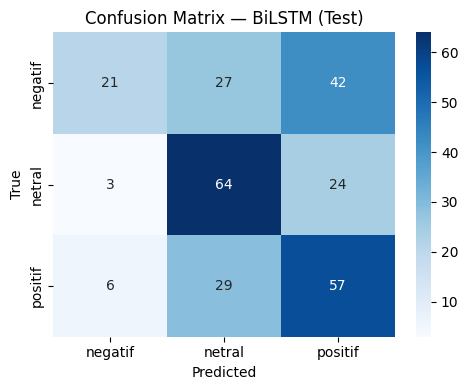

In [46]:
# Evaluasi
train_acc = bilstm.evaluate([Xtr_pad, hq_tr], y_tr, verbose=0)[1]
print(f"\nTraining Accuracy (BiLSTM): {train_acc:.4f}")

y_pred_prob = bilstm.predict([Xte_pad, hq_te], verbose=0)
y_pred      = y_pred_prob.argmax(axis=1)

print("\n[BiLSTM] Test Accuracy:", accuracy_score(y_test, y_pred))
print("[BiLSTM] Classification Report:\n",
      classification_report(y_test, y_pred, target_names=list(le.classes_)))

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=list(le.classes_), columns=list(le.classes_))

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — BiLSTM (Test)")
plt.tight_layout()
plt.show()


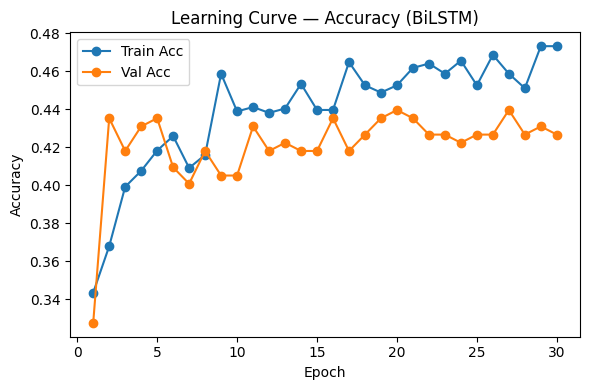

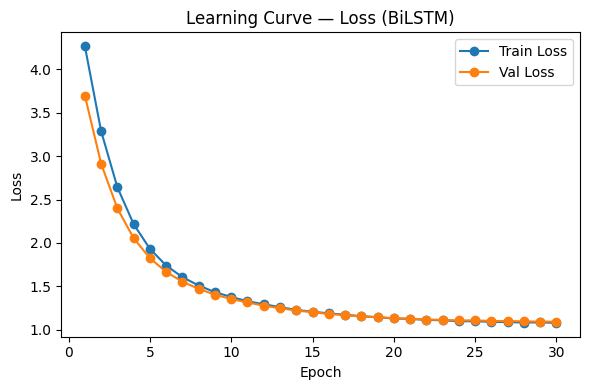

In [29]:
# Learning curve (accuracy & loss per epoch)
epochs_ran    = range(1, len(hitory_lstm.history["accuracy"]) + 1)
train_acc_hist = hitory_lstm.history["accuracy"]
val_acc_hist   = hitory_lstm.history["val_accuracy"]
train_loss_hist = hitory_lstm.history["loss"]
val_loss_hist   = hitory_lstm.history["val_loss"]

plt.figure(figsize=(6,4))
plt.plot(epochs_ran, train_acc_hist, marker="o", label="Train Acc")
plt.plot(epochs_ran, val_acc_hist,   marker="o", label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Learning Curve — Accuracy (BiLSTM)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs_ran, train_loss_hist, marker="o", label="Train Loss")
plt.plot(epochs_ran, val_loss_hist,   marker="o", label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Learning Curve — Loss (BiLSTM)")
plt.legend(); plt.tight_layout(); plt.show()

# **Transformer Model**

In [17]:
import os, json, pickle, math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from transformers import AutoTokenizer, AutoConfig, TFAutoModelForSequenceClassification, create_optimizer
import tf_keras

In [18]:
df = pd.read_csv("tweet_preprocessed(gpt).csv")
df = df.drop_duplicates()
df = df.rename(columns={"text_bert": "teks"})
df = df[['teks','sentimen']]
df["teks"] = df["teks"].astype(str).str.strip()
df["sentimen"] = df["sentimen"].astype(str).str.strip()

SEED = 42
np.random.seed(SEED); tf.random.set_seed(SEED)

# one-hot sesuai urutan ini (pastikan sama di mana-mana)
y_ohe = pd.get_dummies(df["sentimen"], dtype="float32")[["negatif","netral","positif"]].values

X_train_text, X_test_text, y_train, y_test = train_test_split(
    df["teks"].values, y_ohe, test_size=0.30, random_state=SEED, stratify=df["sentimen"]
)

# Split lagi TRAIN -> train kecil & validation eksplisit (untuk threshold tuning)
X_tr_text, X_val_text, y_tr, y_val = train_test_split(
    X_train_text, y_train, test_size=0.10, random_state=SEED, stratify=y_train.argmax(1)
)


In [19]:
MODEL_NAME = "indobenchmark/indobert-base-p1"   
MAX_LEN    = 128
BATCH_TRAIN = 16
BATCH_EVAL  = 32
EPOCHS      = 6

hf_tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def encode_fixed(texts):
    # texts: array-like of str
    return hf_tok(
        pd.Series(texts).tolist(),
        truncation=True,
        padding="max_length",   # fixed length => aman untuk tf.data tanpa collator
        max_length=MAX_LEN,
        return_tensors="tf"
    )

enc_tr  = encode_fixed(X_tr_text)
enc_val = encode_fixed(X_val_text)
enc_te  = encode_fixed(X_test_text)

In [20]:
train_ds = tf.data.Dataset.from_tensor_slices((dict(enc_tr),  y_tr.astype("float32"))) \
                          .shuffle(2048, seed=SEED) \
                          .batch(BATCH_TRAIN) \
                          .prefetch(tf.data.AUTOTUNE)

val_ds   = tf.data.Dataset.from_tensor_slices((dict(enc_val), y_val.astype("float32"))) \
                          .batch(BATCH_EVAL) \
                          .prefetch(tf.data.AUTOTUNE)

test_ds  = tf.data.Dataset.from_tensor_slices((dict(enc_te),  y_test.astype("float32"))) \
                          .batch(BATCH_EVAL) \
                          .prefetch(tf.data.AUTOTUNE)

In [21]:
train_labels_int = y_tr.argmax(axis=1)
classes = np.unique(train_labels_int)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=train_labels_int)
class_weight = {int(c): float(w) for c, w in zip(classes, cw)}
print("class_weight:", class_weight)

class_weight: {0: 1.016, 1: 0.9947780678851175, 2: 0.9896103896103896}


In [22]:
tf.keras.backend.clear_session()

config = AutoConfig.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    problem_type="single_label_classification",
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)

# Optimizer via HF create_optimizer (AdamW + warmup + weight decay)
num_train_examples = len(y_tr)
steps_per_epoch    = math.ceil(num_train_examples / BATCH_TRAIN)
num_train_steps    = steps_per_epoch * EPOCHS
num_warmup_steps   = int(0.1 * num_train_steps)

optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    weight_decay_rate=1e-4
)

# Kompilasi (loss dari logits + label smoothing)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.05),
    metrics=["accuracy"]
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True
)
# (opsional) checkpoint per-epoch terbaik
ckpt = tf.keras.callbacks.ModelCheckpoint(
    "indobert_best_epoch.keras", monitor="val_accuracy",
    save_best_only=True, save_weights_only=False
)


In [ ]:
base = model.layers[0]                
base.trainable = False               
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.05),
              metrics=["accuracy"])
history1 = model.fit(train_ds, validation_data=val_ds,
                     epochs=2, class_weight=class_weight,
                     callbacks=[tf_keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)],
                     verbose=1)

base.trainable = True                  # unfreeze
# kecilkan LR saat unfreeze
from transformers import create_optimizer
steps_per_epoch = int(np.ceil(len(y_tr)/BATCH_TRAIN))
optimizer, _ = create_optimizer(init_lr=1e-5, num_train_steps=steps_per_epoch*EPOCHS, num_warmup_steps=0, weight_decay_rate=1e-4)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.05),
              metrics=["accuracy"])
history2 = model.fit(train_ds, validation_data=val_ds,
                     epochs=EPOCHS, class_weight=class_weight,
                     callbacks=[tf_keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)],
                     verbose=1)

Epoch 1/2
72/72 [==============================] - 153s 2s/step - loss: 1.1139 - accuracy: 0.3412 - val_loss: 1.1055 - val_accuracy: 0.3228
Epoch 2/2
72/72 [==============================] - 130s 2s/step - loss: 1.1003 - accuracy: 0.3508 - val_loss: 1.0938 - val_accuracy: 0.3465
Epoch 1/6
72/72 [==============================] - 409s 5s/step - loss: 0.9675 - accuracy: 0.5468 - val_loss: 0.8576 - val_accuracy: 0.5827
Epoch 2/6
72/72 [==============================] - 376s 5s/step - loss: 0.7885 - accuracy: 0.6728 - val_loss: 0.7674 - val_accuracy: 0.7087
Epoch 3/6
72/72 [==============================] - 377s 5s/step - loss: 0.6714 - accuracy: 0.7498 - val_loss: 0.7777 - val_accuracy: 0.7087
Epoch 4/6
72/72 [==============================] - 374s 5s/step - loss: 0.5832 - accuracy: 0.8119 - val_loss: 0.7994 - val_accuracy: 0.7323
Epoch 5/6
72/72 [==============================] - 373s 5s/step - loss: 0.5291 - accuracy: 0.8320 - val_loss: 0.8304 - val_accuracy: 0.6614
Epoch 6/6
72/72 [===

In [26]:
val_logits = model.predict(val_ds, verbose=0).logits
y_val_prob = tf.nn.softmax(val_logits).numpy()
y_val_true = y_val.argmax(1)

ths = np.linspace(0.30, 0.60, 13)
best_macro, best_t = 0.0, 0.50
for t in ths:
    y_hat = y_val_prob.argmax(1)
    y_hat = np.where(y_val_prob[:,2] >= t, 2, y_hat)
    macro = f1_score(y_val_true, y_hat, average="macro")
    if macro > best_macro:
        best_macro, best_t = macro, t

print("Best threshold positif (val):", best_t, "macro-F1:", round(best_macro,4))

Best threshold positif (val): 0.39999999999999997 macro-F1: 0.7385


== Test Report (IndoBERT) ==
              precision    recall  f1-score   support

     negatif       0.67      0.68      0.68       179
      netral       0.72      0.62      0.66       182
     positif       0.62      0.70      0.66       184

    accuracy                           0.67       545
   macro avg       0.67      0.67      0.67       545
weighted avg       0.67      0.67      0.67       545



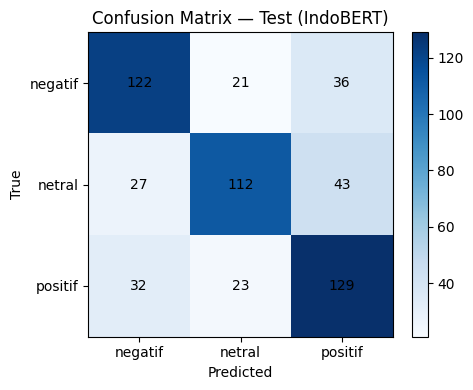

In [27]:
test_logits = model.predict(test_ds, verbose=0).logits
y_test_prob = tf.nn.softmax(test_logits).numpy()
y_test_true = y_test.argmax(1)

y_test_hat  = y_test_prob.argmax(1)
y_test_hat  = np.where(y_test_prob[:,2] >= best_t, 2, y_test_hat)

print("== Test Report (IndoBERT) ==")
print(classification_report(y_test_true, y_test_hat, target_names=["negatif","netral","positif"]))

cm = confusion_matrix(y_test_true, y_test_hat)
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, cmap="Blues")
ax.figure.colorbar(im, ax=ax)
ax.set_xticks(range(3), ["negatif","netral","positif"])
ax.set_yticks(range(3), ["negatif","netral","positif"])
ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title("Confusion Matrix — Test (IndoBERT)")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
plt.tight_layout(); plt.show()

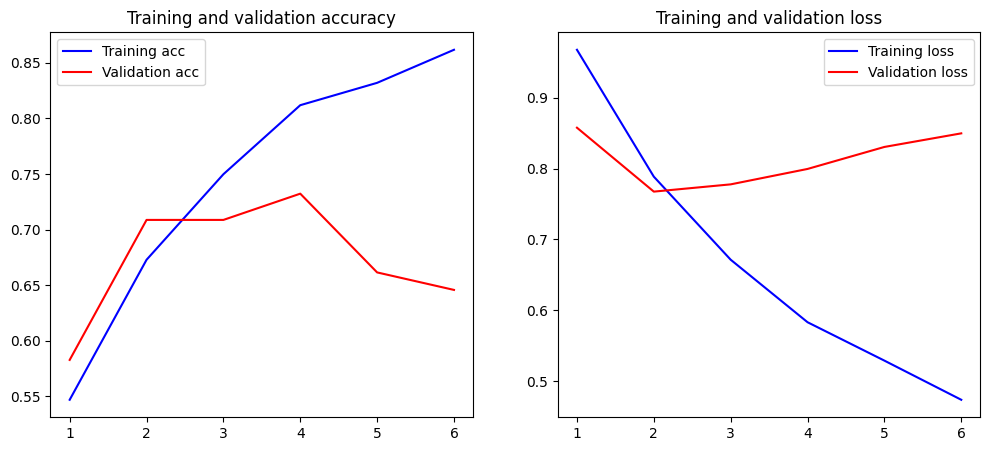

In [29]:
acc = history2.history['accuracy']; val_acc = history2.history['val_accuracy']
loss = history2.history['loss'];     val_loss = history2.history['val_loss']
x_ep = range(1, len(acc)+1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.plot(x_ep, acc, 'b', label='Training acc'); plt.plot(x_ep, val_acc, 'r', label='Validation acc'); plt.legend(); plt.title('Training and validation accuracy')
plt.subplot(1,2,2); plt.plot(x_ep, loss, 'b', label='Training loss'); plt.plot(x_ep, val_loss, 'r', label='Validation loss'); plt.legend(); plt.title('Training and validation loss')
plt.show()